# Association rule mining

You will use:
* orders.csv
* order_products__prior.csv
* products.csv
* aisles.csv (optional but VERY powerful later)

### Step 1 — Merge the tables

In [1]:
import pandas as pd

orders = pd.read_csv("..\data_raw\orders.csv")
order_products = pd.read_csv("..\data_raw\order_products__prior.csv")
products = pd.read_csv("..\data_raw\products.csv")

# Merge product names
df = order_products.merge(products, on="product_id")

df.head()


<>:3: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:4: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:5: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:3: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:4: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:5: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\i025423\AppData\Local\Temp\ipykernel_27600\2970818263.py:3: SyntaxWarning

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


### Step 2: Create baskets

We group products per order:

In [2]:
transactions = df.groupby('order_id')['product_name'].apply(list)
transactions.head()

order_id
2    [Organic Egg Whites, Michigan Organic Kale, Ga...
3    [Total 2% with Strawberry Lowfat Greek Straine...
4    [Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr...
5    [Bag of Organic Bananas, Just Crisp, Parmesan,...
6    [Cleanse, Dryer Sheets Geranium Scent, Clean D...
Name: product_name, dtype: object

### Step 3 — One-Hot Encoding (Basket Matrix)

Association algorithms need:

| order_id | Banana | Milk | Yogurt | Bread |
| -------- | ------ | ---- | ------ | ----- |
| 1        | 1      | 1    | 1      | 0     |
| 2        | 0      | 0    | 1      | 1     |
--------------------------------------------

We create it:


In [3]:
#import sys
#print(sys.executable)
#import sys
#!{sys.executable} -m pip install mlxtend

In [16]:
# because of the RAM error, I will delete rare products (90% of products are almost never bought)
product_counts = df['product_name'].value_counts()

popular_products = product_counts[product_counts > 2500].index

df_filtered = df[df['product_name'].isin(popular_products)]


In [17]:
# Limit commands :
# Instacart df contain the entire history of the cliens so we will consider only a sample
sample_orders = df_filtered['order_id'].drop_duplicates().sample(100000, random_state=42)

df_filtered = df_filtered[df_filtered['order_id'].isin(sample_orders)]

# Step 3: Recreate the trandactions DF
transactions = df_filtered.groupby('order_id')['product_name'].apply(list)


In [18]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

basket = pd.DataFrame(te_ary, columns=te.columns_)
basket.head()

,0% Fat Free Organic Milk,0% Greek Strained Yogurt,1 Liter,1 Ply Paper Towels,1% Low Fat Milk,1% Lowfat Milk,1% Milkfat Low Fat Buttermilk,100 Calorie Per Bag Popcorn,100% Apple Juice,100% Cranberry Juice,...,"Yogurt, Strained Low-Fat, Coconut",Yotoddler Organic Pear Spinach Mango Yogurt,Yukon Gold Potatoes 5lb Bag,ZBar Organic Chocolate Brownie Energy Snack,Zen Tea,Zero Calorie Cola,Zero Soda,of Hanover 100 Calorie Pretzels Mini,smartwater® Electrolyte Enhanced Water,with Crispy Almonds Cereal
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Association rules Explaination: 


Here are some key takes from the rules tables, to explain the meaning of each column:

* __🧠Support__: _support(A,B)_ = Frequency of occurrence of baskets containing both A and B.
    
    support = 0.02

    → 2% of baskets contains both products

    👉 Used to determine whether the rule is statistically reliable.

* __🧠Confidence__: _confidence(A→B) = P(B | A)_ When a customer buys A, what is the probability that they will also buy B?
    _Strawberries → Banana_
    _confidence = 0.68_ Means that 68% of clients who bought strawberry also bought banana
* __🧠Lift__: Actual dependence between products
    - lift = 1 → hasard (no link)
    - lift > 1 → linked products
    - lift > 2 → very strong realation shape

In [19]:

from mlxtend.frequent_patterns import apriori, association_rules

# itemsets fréquents
frequent_itemsets = apriori(
    basket,
    min_support=0.01,
    use_colnames=True
)

# règles d'association
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.2
)

rules.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,frozenset({Bag of Organic Bananas}),frozenset({Organic Baby Spinach}),0.12338,0.07884,0.01665,0.134949,1.711681,1.0,0.006923,1.064862,0.474298,0.089724,0.060911,0.173068
1,frozenset({Organic Baby Spinach}),frozenset({Bag of Organic Bananas}),0.07884,0.12338,0.01665,0.211187,1.711681,1.0,0.006923,1.111316,0.451365,0.089724,0.100166,0.173068
2,frozenset({Organic Hass Avocado}),frozenset({Bag of Organic Bananas}),0.07029,0.12338,0.02032,0.289088,2.343071,1.0,0.011648,1.233092,0.616547,0.117219,0.189031,0.226891
3,frozenset({Bag of Organic Bananas}),frozenset({Organic Hass Avocado}),0.12338,0.07029,0.02032,0.164694,2.343071,1.0,0.011648,1.113018,0.653886,0.117219,0.101542,0.226891
4,frozenset({Organic Raspberries}),frozenset({Bag of Organic Bananas}),0.04485,0.12338,0.01355,0.302118,2.448680,1.0,0.008016,1.256115,0.619397,0.087600,0.203895,0.205971


In [8]:
rules.columns

Index(['antecedents', 'consequents', 'antecedent support',
       'consequent support', 'support', 'confidence', 'lift',
       'representativity', 'leverage', 'conviction', 'zhangs_metric',
       'jaccard', 'certainty', 'kulczynski'],
      dtype='str')

In [20]:
strong_rules = rules[
    (rules['confidence'] > 0.01) &
    (rules['lift'] > 1.8) &
    (rules['support'] > 0.01)
].sort_values(by='lift', ascending=False)

strong_rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
30,frozenset({Organic Raspberries}),frozenset({Organic Strawberries}),0.04485,0.08590,0.01182,0.263545,3.068046,1.0,0.007967,1.241217,0.705711,0.099386,0.194339,0.200574
31,frozenset({Organic Strawberries}),frozenset({Organic Raspberries}),0.08590,0.04485,0.01182,0.137602,3.068046,1.0,0.007967,1.107551,0.737403,0.099386,0.097107,0.200574
5,frozenset({Bag of Organic Bananas}),frozenset({Organic Raspberries}),0.12338,0.04485,0.01355,0.109823,2.448680,1.0,0.008016,1.072989,0.674884,0.087600,0.068024,0.205971
4,frozenset({Organic Raspberries}),frozenset({Bag of Organic Bananas}),0.04485,0.12338,0.01355,0.302118,2.448680,1.0,0.008016,1.256115,0.619397,0.087600,0.203895,0.205971
16,frozenset({Organic Fuji Apple}),frozenset({Banana}),0.02814,0.15346,0.01057,0.375622,2.447686,1.0,0.006252,1.355813,0.608576,0.061802,0.262435,0.222250
17,frozenset({Banana}),frozenset({Organic Fuji Apple}),0.15346,0.02814,0.01057,0.068878,2.447686,1.0,0.006252,1.043751,0.698669,0.061802,0.041917,0.222250
3,frozenset({Bag of Organic Bananas}),frozenset({Organic Hass Avocado}),0.12338,0.07029,0.02032,0.164694,2.343071,1.0,0.011648,1.113018,0.653886,0.117219,0.101542,0.226891
2,frozenset({Organic Hass Avocado}),frozenset({Bag of Organic Bananas}),0.07029,0.12338,0.02032,0.289088,2.343071,1.0,0.011648,1.233092,0.616547,0.117219,0.189031,0.226891
22,frozenset({Organic Baby Spinach}),frozenset({Organic Avocado}),0.07884,0.05728,0.01051,0.133308,2.327304,1.0,0.005994,1.087722,0.619130,0.083672,0.080647,0.158396
23,frozenset({Organic Avocado}),frozenset({Organic Baby Spinach}),0.05728,0.07884,0.01051,0.183485,2.327304,1.0,0.005994,1.128160,0.604971,0.083672,0.113601,0.158396


In [21]:
def recommend(product_name, rules, top_n=5):

    recs = rules[rules['antecedents'].apply(lambda x: product_name in x)]

    recs = recs.sort_values('lift', ascending=False)

    return recs[['consequents','confidence','lift']].head(top_n)

recommend('Banana', rules)

,consequents,confidence,lift
17,frozenset({Organic Fuji Apple}),0.068878,2.447686
12,frozenset({Organic Avocado}),0.112212,1.959002
20,frozenset({Strawberries}),0.087840,1.907917
9,frozenset({Large Lemon}),0.081780,1.690024
11,frozenset({Limes}),0.067379,1.489700


In [ ]:
#!pip install networkx

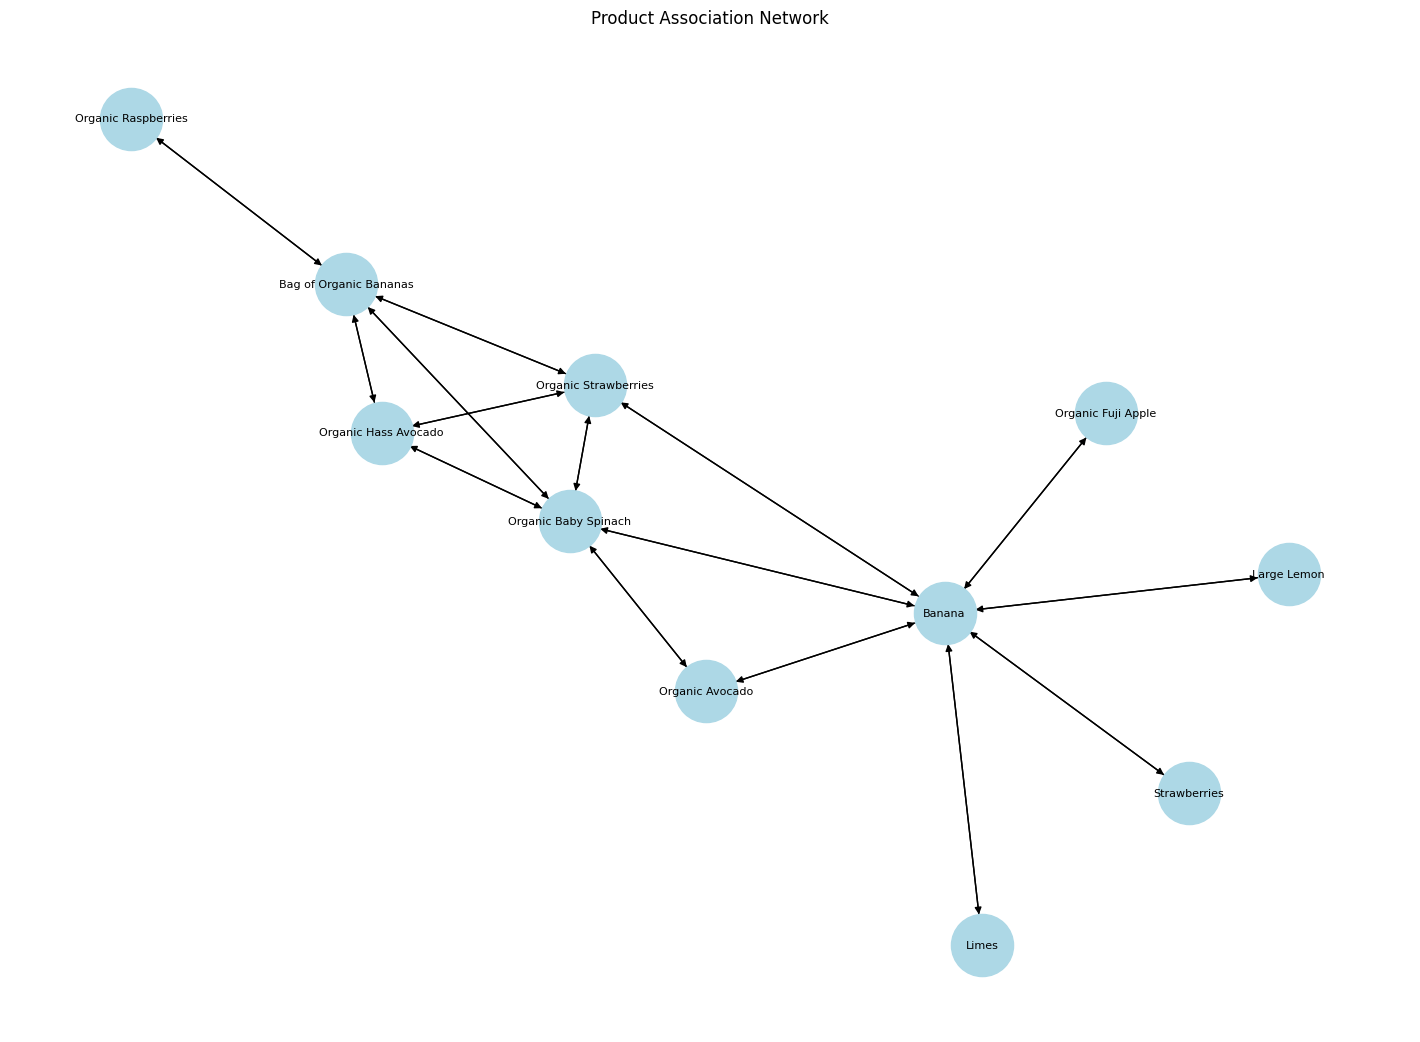

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for _, row in rules.head(30).iterrows():
    for a in row['antecedents']:
        for b in row['consequents']:
            G.add_edge(a, b, weight=row['lift'])

plt.figure(figsize=(14,10))
pos = nx.spring_layout(G, k=0.6)

nx.draw(G, pos,
        with_labels=True,
        node_size=2000,
        node_color="lightblue",
        font_size=8,
        arrows=True)

plt.title("Product Association Network")
plt.show()


#### Results and interpretations

<h5>1- How to read the graph?</h5>

This graph represents a "supermarket mental map". 

* Each node = a product. (A-->B means customers who buy A are likely to also buy B).
* Each arrow = a behavioral relationship.
* The closer products appear --> the more they belong to the same consumption context.

Here we did not cluster customer, we clustered __meals and lifestyles__.

<h5>2- The most important node</h5>

In this graph "Banana" product represents a __"Basket Anchor Product"__ which is an item purchased by a very large number of customers and that triggers other purchases. 

From this graph we have: 

- Banana -> Organic Avocado
- Banana -> Organic Fuji Apple
- Banana -> Strawberries

__Banana__ is not just popular. It predicts _fruit basket contruction_. 

__Banana__ is a traffic generator product. Which means a any discount applied to Bananas will pull other items from this list into the basket.

<h5> The <strong>"Healthy Lifestyle Cluster"</strong></h5>

Let's look at this group: 

- Organic Hass Avocado
- Organic Baby Spinach
- Organic Strawberries
- Organic Raspberries
- Organic Bananas

This is extremly important as we discovered a behavioral segment without using customer demographics. These products correspond to: Smoothies, salads, diet/fitness consumption and plant-based eating. 

We did 
